Source of data: https://data.stackexchange.com/stackoverflow/query/edit/960504  
SQL request: SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2016' AND Tags IS NOT NULL AND Score > 10

good ressource: [here](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

01. <a href="#1.-Import-and-cleaning-data">Import and cleaning data</a>  
    1.1 <a href="#1.1-Tag-processing">Tag processing</a>  
    1.2 <a href="#1.2-Corpus-processing">Corpus processing</a>  
    1.3 <a href="#1.3-Feature-engineering">Feature engineering</a>  
02. <a href="#2.-Unsupervised-learning">Unsupervised learning</a>  
    2.1 <a href="#2.1-LDA:-LatentDirichletAllocation">LDA: LatentDirichletAllocation</a>  
    2.2 <a href="#2.2-NMF:-Negative-Matrix-Factorisation">NMF: Negative Matrix Factorisation</a>  
03. <a href="#3.-Supervised-learning">Supervised learning</a>



## 1. Import and cleaning data
The first cleaning consist mainly on removing some specific characters (":", "*", "[", ...) and html/xml tags.

In [1]:
# import data
import pandas as pd
import nltk   # Natural Language Toolkit

text = pd.read_csv("QueryResults.csv", index_col=0)
text_df = text.sample(10000)   # to limit processing time
text_df.head(5)

,Body,Title,Tags,LastActivityDate,Score
Id,,,,,
1241429,"<p>Once upon a time I bumped into <a href=""htt...",Blocking IO vs non-blocking IO; looking for go...,<events><blocking><nonblocking><io>,2018-06-26 09:22:41,42
2329460,"<p>In my reading on dynamic and static typing,...",Which languages are dynamically typed and comp...,<programming-languages><type-systems><dynamic-...,2017-01-12 16:59:53,36
1326570,<p>I want to hide any scrollbars from my <code...,How can I disable a browser or element scrollb...,<javascript><jquery><css><browser><scrollbar>,2018-01-11 16:16:25,51
10857393,"<p>I have these date and time fields, and I wa...",how to make label visible/invisible?,<javascript><html><label>,2018-07-04 08:56:26,15
531502,<p>Is it possible to build resources into a st...,VC++ resources in a static library,<visual-c++><resources><static-libraries>,2017-03-31 18:09:10,33


In [2]:
# Merge Body and Title columns
corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]
corpora.head()

Id
1241429     Blocking IO vs non-blocking IO; looking for go...
2329460     Which languages are dynamically typed and comp...
1326570     How can I disable a browser or element scrollb...
10857393    how to make label visible/invisible?<p>I have ...
531502      VC++ resources in a static library<p>Is it pos...
dtype: object

In [3]:
# clean text function
import re   # Regular expression library

def cleantext(raw_text):
    """clean raw text: 
           1. remove markups
           2. remove some special characters
           3. lower all"""
    
    #1. remove markups
    cleanr = re.compile('<.*?>')  
    cleantext = re.sub(cleanr, ' ', raw_text)
    
    #2. remove special characters
    element2remove = [r"\.\s", r'"', r"'", r"\!", r"\?", r"\,",
                      r"\:", "\(", "\)", "\n", "\*", "\]", "\[", "&nbsp;",
                      "&lt;", "\//", "=", "\{", "\}", "&gt;"]                   
    for e in element2remove:
        cleantext = re.sub(e, ' ', cleantext)
        
    #3. lower all (remove Capital letters)   
    cleantext = cleantext.lower() 
    
    return cleantext

In [4]:
corpora = corpora.apply(cleantext)
corpora.iloc[0]

'blocking io vs non-blocking io; looking for good articles once upon a time i bumped into  introduction to indy  article and can t stop thinking about blocking vs non-blocking io ever since then    looking for some good articles describing what are pros and cons of blocking io and non-blocking io and  how to design your application in each case  to get natural  easy to understand and easy to maintain code  would like to understand big picture..  '

### 1.1 Tag processing
In this section we will clean and explore the tag columns.

In [5]:
# clean tags
tags = text_df.loc[:, "Tags"]

def cleantags(tags):
    """clean raw tags"""
    #remove markups
    tags = tags.replace("><", ' ')
    tags = tags.replace("<", '')
    tags = tags.replace(">", '')
    tags = tags.lower()  # remove capital letters
    return tags

tags = tags.apply(cleantags)
tags.head()

Id
1241429                        events blocking nonblocking io
2329460     programming-languages type-systems dynamic-typ...
1326570               javascript jquery css browser scrollbar
10857393                                javascript html label
531502                  visual-c++ resources static-libraries
Name: Tags, dtype: object

In [6]:
# lists of tags
all_tags = []       # list of all tags
primary_tags = []   # list of first tags (= the most relevent for each docs)
document_tags =  [] # "list of list" of tags for each document
for line in tags:
    tag = line.split()
    primary_tags.append(tag[0])
    document_tags.append(tag)
    for w in tag:
        all_tags.append(w)
        
primary_tags = nltk.FreqDist(primary_tags)   # ~ dict type
all_tags = nltk.FreqDist(all_tags)           # ~ dict type

In [7]:
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])
cum_sum = df_1["freq_all"].cumsum()  #


In [8]:
cum_sum.tail()

5471    30387
5472    30388
5473    30389
5474    30390
5475    30391
Name: freq_all, dtype: int64

In [9]:
# most common tags plot
import matplotlib.pyplot as plt
import seaborn as sns

# inputs
top_n = 75
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])
df_2 = pd.DataFrame(primary_tags.most_common(), columns=["tags","freq_primary"])  
df = pd.merge(df_1, df_2, how="left" )

# plot
plt.figure(figsize=(15,7))
plt.title("Top tags by frequency", fontweight="bold", size=20)
sns.barplot(y= "freq_all", x= "tags", data= df.loc[0:top_n, :], label="Total")
plt.xticks(rotation=80, size=10)
plt.xlabel("Tags", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()

<Figure size 1500x700 with 1 Axes>

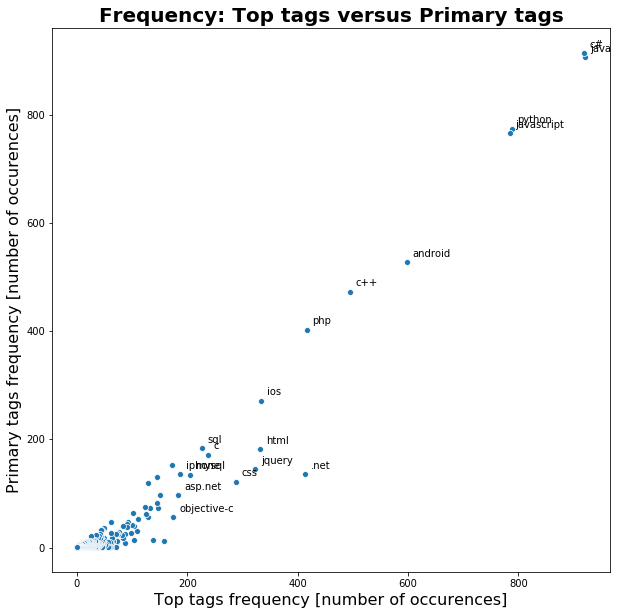

In [10]:
# relation in-beetwee frequency on top tags and primary tags 
plt.figure(figsize=(10, 10))
plt.title("Frequency: Top tags versus Primary tags", fontweight="bold", size = 20)
sns.scatterplot(x="freq_all", y="freq_primary", data=df)
# plt.scatter(x="freq_all", y="freq_primary", data=df, label="Total",marker="+", s=75)

for i in range(0,18):
    plt.annotate(df.loc[i,"tags"],
                 (df.loc[i,"freq_all"]+10, df.loc[i,"freq_primary"]+10),
                 size=10)

plt.xlabel("Top tags frequency [number of occurences]", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()  

Clear correlation from primary tags freq and all tags frequency. For the rest we will select the top 150 tags (as it decreases very slowly in this area)

In [11]:
# creaton of top tag list
top_n = 150
top_t = list(df.loc[0:top_n-1, "tags"])

# Extra infos
count_top = df.loc[0:top_n, "freq_all"].sum()
count_all = df["freq_all"].sum()
fract_t = round(top_n/len(df),2)*100
fract_v = round(count_top/count_all,3)*100
print("The top {} tags ({}% of the tag population)\
represent {}% in term of volume/occurences.".format(top_n, fract_t, fract_v))

The top 150 tags (3.0% of the tag population)represent 50.5% in term of volume/occurences.


### 1.2 Corpus processing
In this section we will clean and explore the corpus (body columns).

In [12]:
# Part of Speech Tagging
import nltk
from nltk.tokenize import PunktSentenceTokenizer   # already train sentence tokensier
from nltk.corpus import stopwords

# --------------------------------------------------------------------------------

# standard stopwords list from nltk library
stopwords = set(stopwords.words("english"))

# updated with some specific words
stopwords.update(["p","/p","way","=","something", "anyone", "possible", "good", "example",
                 "question", "solution", "able", "different", "first", 'following',
                  "anything", 'help', 'thing','sure', 'many', 'lot', 'much', "several",
                  "wrong", "right", "idea", "easy", "everything", "difference", "|",
                 "certain", "kind", "great", "nothing", "answer", "please", "little",
                 "/", "\&gt;", "+", "..", "\=&gt;", "specific", "code", "new", "name",
                 "error"])

def process_content(text_body, stopwords):
    """
    Tokenize a text ('text_body') by words and keep the nouns(NN) and adjective or numeral, ordinal (JJ) 
    then remove stop words ('stopwords').
    Inputs:
        - text_body: string
        - stopwords: list of string
    Outputs:
        - return a list of words selection
        """
    
    tokenizer = PunktSentenceTokenizer()
    tokenized = tokenizer.tokenize(text_body)
    all_nouns = []   
    for sentence in tokenized:
        # words = nltk.word_tokenize(sentence)
        words = sentence.split()
        # get the information of the word (noune, verb,etc..)
        tagged = nltk.pos_tag(words)  
        for w in tagged:
            if ((w[1] == "NN")or(w[1] == "JJ")) and (w[0] not in stopwords):
                all_nouns.append(w[0])
    return all_nouns

In [13]:
# list of processed words
all_words = []
for body in corpora:
    tokenized_body = process_content(body, stopwords)
    for w in tokenized_body:
        all_words.append(w)
all_words = nltk.FreqDist(all_words)   # ~ dict type
print("{} words have been extracted".format(len(all_words)))

57126 words have been extracted


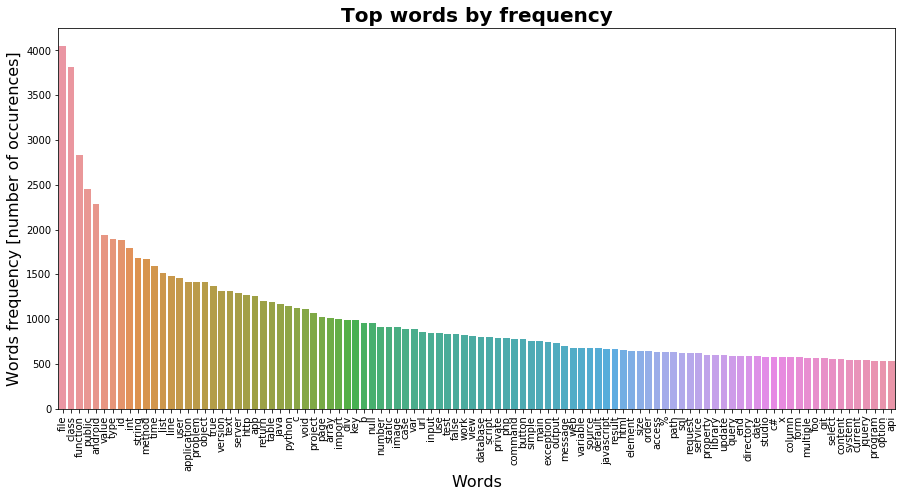

In [14]:
# most frequent words
# inputs
top_n = 100
df = pd.DataFrame(all_words.most_common(top_n), columns=["words","freq"])

# plot
plt.figure(figsize=(15,7))
plt.title("Top words by frequency", fontweight="bold", size=20)
plt.xticks(rotation=90, size=10)
sns.barplot(y="freq", x="words", data=df.loc[0:top_n, :], label="Total");
plt.xlabel("Words", size=16)
plt.ylabel("Words frequency [number of occurences]", size=16)
plt.show()

In [15]:
all_words.most_common(10)

[('file', 4047),
 ('class', 3812),
 ('function', 2837),
 ('public', 2456),
 ('android', 2291),
 ('value', 1936),
 ('type', 1890),
 ('id', 1883),
 ('int', 1795),
 ('string', 1684),
 ('method', 1674),
 ('time', 1597),
 ('list', 1519),
 ('line', 1481),
 ('user', 1454)]

In [16]:
# Build vocabulary dict based on the most fequent words
number_of_top_words = 500
top_w = list(zip(*all_words.most_common(number_of_top_words)))[0]

# add top tags to this list
top_w = set(list(top_w) + list(top_t))
len(top_w)

593

### 1.3 Feature engineering
In this section, based on our corpus and list of most commons words, we will create new features that can be used as input for our models:
- TF Term Frequency table: for each documents (row) we will compute the frequency of the most frequent words (columns)
- TF-IDF Term Frequency - Inverse Document Frequency: The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This help to reduce the importance of the very commons words. More information [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
First, to build those tables we need to select wich feature/words that would be used as input. For this we will run several times:
    1. Create a vocabulary list
    2. Create TF and TF-IDF Table 
    3. Run the LDA model
    4. Model score evaluation  

On each loops we will change the initial vocabulary list, and see the impact on the final scoring.  
    

 

In [17]:
# formating input for the vocabulaty list
def vocabulary(all_words, all_tags, Nw, Nt):
    """ return a dictionary of vocabulary. It merges the top Nw words from all_words
    with the top Nt from all_tags. This format is needed as input of nltk vectoriser"""
    top_w = list(zip(*all_words.most_common(Nw)))[0]
    top_t = list(zip(*all_tags.most_common(Nt)))[0]
    # add top tags to this list
    top_w = set(list(top_w) + list(top_t))

    # formating: list of for for vectorized input
    return dict(zip(top_w, range(0, len(top_w))))

In [45]:
document_tags

[['events', 'blocking', 'nonblocking', 'io'],
 ['programming-languages', 'type-systems', 'dynamic-typing', 'static-typing'],
 ['javascript', 'jquery', 'css', 'browser', 'scrollbar'],
 ['javascript', 'html', 'label'],
 ['visual-c++', 'resources', 'static-libraries'],
 ['c#', 'datetime', '.net-2.0'],
 ['jquery'],
 ['regex', 'shell', 'curl'],
 ['c#', 'browser', 'desktop-application'],
 ['objective-c', 'cocoa-touch', 'cocoa', 'nsarray', 'deep-copy'],
 ['c++', 'gcc'],
 ['c', 'stack', 'malloc', 'allocation', 'alloca'],
 ['javascript', 'onkeydown'],
 ['c++', 'com'],
 ['android', 'android-activity', 'android-broadcast'],
 ['asp.net-mvc', 'webforms'],
 ['android'],
 ['ios', 'http', 'url', 'uiwebview', 'hyperlink'],
 ['java', 'multithreading', 'executorservice', 'shutdown'],
 ['android', 'ios', 'html5', 'svg', 'mobile-website'],
 ['php', 'regex', 'string'],
 ['java', 'android', 'android-studio', 'java-8', 'android-studio-2.2'],
 ['svn', 'tortoisesvn', 'branch'],
 ['javascript', 'three.js', 'webg

In [44]:
# Functions used for the scoring evaluations
# Note: The words return here are the top X based on the number of occurence
# could be better the have the top percentage compare to the complete Corpus

def display_topics2(model, feature_names, no_top_words=25):
    """create a panda data frame of the top words present in each topics.
    inputs: 
        - model: fitted model, from where we will extract the results (numeric)
        - feature_names: list of string (words used in the model)
        - no_top_words: int, the number of top words per topics we want to extract
    output:
        - Pandas data frame 
        """
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict["Topic%d" % (topic_idx)] = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(word_dict).T

def topic_score(model, vectorized_input, feature_names, top_t, document_tags):
    """The scoring function is design for the purpose off assessing the quality of the predicted tag
    in the context of tags suggestion. For tis we will compute the ratio of real tags words present
    in the predicted list of tags.
    Inputs: 
        - model: fitted sklearn model, from where we will extract the results (numeric).
        - vectorized_input: tf or tf-idf vectorized input
        - feature_names: list of string (words used in the model)
        - document_tags: list of list of str, each document has a list of real tags
        - top_t: list of str, all existing tags 
    Output:
        - score: float, [0:1]
        """

    # topic df ----------------------------------------------------------------------------
    topic_df = display_topics2(model, feature_names, no_top_words=25)
    # associate each topic with a list of tags
    topics_kwords_df = (topic_df.isin(top_t)*topic_df).T
    topic2tags_d = {}
    tags_per_topic = []
    for topic in topics_kwords_df:
        tag_list = []
        for e in topics_kwords_df.loc[:, topic]:
            if e is not "":
                tag_list.append(e)
        topic2tags_d[topic] = tag_list

    # Create Document Vs Topic Matrix ------------------------------------------------------
    model_output = model.transform(vectorized_input)
    # column names
    topicnames = ["Topic" + str(i) for i in range(model.components_.shape[0])]
    # index names
    docnames = ["Post" + str(i) for i in range(vectorized_input.shape[0])]
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)

    # Tag prediction -----------------------------------------------------------------------
    treshold = 0.20
    tag_pred = []
    for post in df_document_topic.index:
        tags_post = []
        mask = df_document_topic.loc[post, :] >= treshold
        topic_pred = list(df_document_topic.loc[post, mask].index)
        for topic in topic_pred:
            tags_post = tags_post + topic2tags_d[topic].copy()
        tag_pred.append(tags_post)

    # Scoring ----------------------------------------------------------------------------------
    tag_score = []   # list of score for each document (score = ratio of real tags present in the prediction)
    for i in range(len(document_tags)):
        score = 0 
        count_e = 0
        for e in document_tags[i]:
            if e in tag_pred[i]:
                score = score + 1
            count_e = count_e + 1
        tag_score.append(round(score/count_e,2))

    return sum(tag_score)/len(tag_score)

In [21]:
# Manual grid seach on the composition of vocabulary

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

n_top_w = [1,50,100,300]
n_top_t = [100,150,200,300]

grid_score_tf = pd.DataFrame(0, index = n_top_w, columns= n_top_t) 
grid_score_tf.index.name = "n_top_w"
grid_score_tf.columns.name = "n_top_t"
grid_score_tfidf = grid_score_tf.copy()

for w in n_top_w:
    for t in n_top_t:

        voca = vocabulary(all_words, all_tags, w, t)
        
        # tf
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, 
                                        vocabulary=voca,
                                        stop_words=stopwords)
        tf = tf_vectorizer.fit_transform(corpora)

        # tf-idf
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                           vocabulary=voca,
                                           stop_words=stopwords)
        tfidf = tfidf_vectorizer.fit_transform(corpora)

        # extraction of feature names
        feature_names = tf_vectorizer.get_feature_names()     
        
        no_topics = 25  # hyperparametre (a tester)
        # Run LDA on tf
        lda_tf = LatentDirichletAllocation(n_topics=no_topics, 
                                            topic_word_prior=0.1,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                            doc_topic_prior=0.1,    # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                            max_iter=100, 
                                            learning_method='online', 
                                            learning_offset=50.,
                                            random_state=0).fit(tf)

        # Run LDA on tfidf
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                        max_iter=5, 
                                        learning_method='online', 
                                        learning_offset=50.,
                                        random_state=0).fit(tfidf)
        
        grid_score_tf.loc[w, t ] = topic_score(lda_tf, tf, feature_names, top_t)
        grid_score_tfidf.loc[w, t ] = topic_score(lda_tfidf, tfidf, feature_names, top_t)
        print("loops W=",w,"  T=",t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 300


In [22]:
grid_score_tf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.274707,0.287055,0.254498,0.242215
50,0.210819,0.215718,0.214048,0.213889
100,0.203384,0.212533,0.217489,0.203180
300,0.164071,0.180824,0.175040,0.189486


In [23]:
grid_score_tfidf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.276984,0.292569,0.291137,0.278990
50,0.246920,0.264959,0.265817,0.267647
100,0.233669,0.259582,0.254602,0.250112
300,0.199697,0.218764,0.223495,0.216775


The best score is obtain when the vocabulary input list is a combinaison of the top 1 words and the top 150 tags. It is quite instinctive that the chance of getting a correct tags is better if from the start, we select only the tags words as feature.
However here, we might also want the futur tag recomendation engine to be able to also produce new tags (IT world is changing all the time). So even if it degrade a little bit our final quality we would introduce the 25 top words from the corpus.

In [48]:
# countage, frequence d apparition de chaque mot dans une matrice
from sklearn.feature_extraction.text import CountVectorizer

# to match vectorizer input format, the list is
# convert to vocabulary dictionary: {word: index}

voca = vocabulary(all_words, all_tags, 25, 150)

# tf
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, 
                                vocabulary=voca,
                                stop_words=stopwords)
tf = tf_vectorizer.fit_transform(corpora)
feature_names = tf_vectorizer.get_feature_names()


# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   vocabulary=voca,
                                   stop_words=stopwords)
tfidf = tfidf_vectorizer.fit_transform(corpora)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [49]:
# Materialize the sparse data
data_dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.348809523809524 %


## 3.LDA: LatentDirichletAllocation

In [38]:
from sklearn.decomposition import LatentDirichletAllocation
no_topics = 25  # hyperparametre (a tester)

# Run LDA on tf
lda_tf = LatentDirichletAllocation(n_topics=no_topics, 
                                    topic_word_prior=0.1,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=0.1,    # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=100, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tf)

# Run LDA on tfidf
lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(tfidf)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [50]:
# A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.
print("LDA with tf---------------------------------------------------------")

# Log Likelyhood: Higher the better
print("Log Likelihood: ", round(lda_tf.score(tf),0))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", round(lda_tf.perplexity(tf),0))

print("LDA with tfidf---------------------------------------------------------")
print("Log Likelihood: ", round(lda_tfidf.score(tfidf),0))
print("Perplexity: ", round(lda_tfidf.perplexity(tfidf),0))

LDA with tf---------------------------------------------------------
Log Likelihood:  -337313.0
Perplexity:  34.0
LDA with tfidf---------------------------------------------------------
Log Likelihood:  -95904.0
Perplexity:  419.0


In [249]:
(lda_tf.components_).shape

(25, 1065)

In [54]:
display_topics2(lda_tf, feature_names, no_top_words=10)

,0,1,2,3,4,5,6,7,8,9
Topic0,sql,scala,pdf,html5,shell,tsql,logging,parsing,linq,exception
Topic1,android,list,gradle,linq,xml,app,collections,generics,problem,version
Topic2,date,go,datetime,shell,debugging,oracle,unix,exception,tsql,parsing
Topic3,true,css,syntax,forms,typescript,macos,css3,generics,collections,security
Topic4,html,ajax,type,javascript,jquery,templates,url,text,scripting,http
Topic5,user,server,php,authentication,ssh,security,ssl,problem,tsql,testing
Topic6,numpy,lambda,dataframe,pandas,problem,linq,gcc,collections,performance,variables
Topic7,ios,iphone,svn,powershell,mongodb,xcode,swift,app,version,scripting
Topic8,app,windows,mysql,ruby,testing,firebase,parsing,linux,cmd,api
Topic9,return,git,variables,github,optimization,rest,collections,ssh,exception,scripting


In [31]:
topic_df = display_topics2(lda_tf, tf_feature_names, no_top_words=20)
topic_df.shape

(25, 20)

In [52]:
(topic_df.isin(top_t)*topic_df).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic0,http,url,xml,spring,templates,html5,html,php,windows,docker,rest,json,class,exception,file,string,maven,image,javascript,security
Topic1,exception,syntax,bash,debugging,stl,ubuntu,scripting,windows,shell,reflection,class,logging,string,xml,inheritance,spring,unix,file,variables,http
Topic2,file,vim,stl,xml,sorting,ubuntu,logging,windows,image,cmd,maven,ssh,firebase,reflection,gcc,oop,http,testing,interface,scripting
Topic3,performance,wpf,lambda,optimization,winforms,types,gcc,windows,reflection,stl,linq,oop,interface,algorithm,variables,http,syntax,arrays,function,class
Topic4,go,security,regex,ssl,ssh,ubuntu,cmd,spring,windows,docker,scripting,oracle,http,authentication,shell,exception,php,image,interface,html
Topic5,angular,dictionary,shell,algorithm,angularjs,typescript,sorting,scripting,templates,optimization,html,http,interface,debugging,math,forms,function,types,laravel,json
Topic6,string,spring,multithreading,class,reflection,types,interface,linq,cmd,xml,stl,exception,collections,java,security,windows,html,php,http,json
Topic7,database,postgresql,sqlite,reflection,tsql,oop,sql,types,rest,ubuntu,docker,xml,php,spring,mysql,optimization,mongodb,ruby,file,django
Topic8,hibernate,forms,collections,parsing,haskell,spring,postgresql,exception,authentication,django,class,scripting,windows,xml,java,types,http,winforms,logging,sql
Topic9,powershell,qt,cocoa,generics,css3,cmd,scripting,interface,windows,oop,debugging,gcc,variables,file,ubuntu,go,function,logging,swift,math


In [20]:
# associate each topic with a list of tags
topics_kwords_df = (topic_df.isin(top_t)*topic_df).T

topic2tags_d = {}
tags_per_topic = []
for topic in topics_kwords_df:
    tag_list = []
    for e in topics_kwords_df.loc[:, topic]:
        if e is not "":
            tag_list.append(e)
    topic2tags_d[topic] = tag_list
topic2tags_d

NameError: name 'topic_df' is not defined

In [33]:
topic_df = display_topics2(lda_tf, tf_feature_names, no_top_words=20)
topic_df = topic_df.T

In [34]:
topic_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24
0,http,exception,file,performance,go,angular,string,database,hibernate,powershell,...,java,mysql,api,date,function,list,json,git,html,linux
1,url,syntax,vim,wpf,security,dictionary,spring,postgresql,forms,qt,...,scala,testing,authentication,variables,gcc,linq,jquery,ios,windows,github
2,xml,bash,stl,lambda,regex,shell,multithreading,sqlite,collections,cocoa,...,maven,rest,perl,datetime,math,collections,types,xcode,javascript,npm
3,spring,debugging,xml,optimization,ssl,algorithm,class,reflection,parsing,generics,...,docker,mongodb,html5,validation,ubuntu,types,ajax,iphone,css,unix
4,templates,stl,sorting,winforms,ssh,angularjs,reflection,tsql,haskell,css3,...,spring,html5,templates,reactjs,laravel,class,swift,svn,ruby,inheritance
5,html5,ubuntu,ubuntu,types,ubuntu,typescript,types,oop,spring,cmd,...,exception,php,rest,oop,javascript,vim,javascript,html5,html5,macos
6,html,scripting,logging,gcc,cmd,sorting,interface,sql,postgresql,scripting,...,cmd,multithreading,docker,html5,php,string,dom,cmd,cmd,ubuntu
7,php,windows,windows,windows,spring,scripting,linq,types,exception,interface,...,xml,ubuntu,http,javascript,html5,interface,reactjs,interface,templates,windows
8,windows,shell,image,reflection,windows,templates,cmd,rest,authentication,windows,...,logging,cmd,php,tsql,oop,tsql,html5,ssh,jquery,cmd
9,docker,reflection,cmd,stl,docker,optimization,xml,ubuntu,django,oop,...,interface,templates,json,url,reactjs,python,function,github,http,gcc


In [40]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

C:\Users\ben\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
3       49.995419 -121.886948       1        1  6.819964
5       28.936361   27.058941       2        1  6.418037
11     137.722870  -90.593887       3        1  6.196002
18      51.308693  194.683151       4        1  5.570656
13     -75.800240 -199.085312       5        1  5.434711
14      14.721141 -200.373367       6        1  5.165349
10     223.932190   78.022148       7        1  4.923303
0      186.145386   -5.154973       8        1  4.903324
21     -53.165798   55.628609       9        1  4.858283
1     -143.735611  -26.290457      10        1  4.594604
20     102.279579  -17.798834      11        1  4.419174
15    -145.293198   68.504097      12        1  3.944706
17     -34.215294  140.229782      13        1  3.862568
8       42.793190  104.103539      14        1  3.686037
22     -54.153183  -24.468641      15        1  3.592949
6      -43.025471 -107.650703      16        1  3.425217
19     209.519791 -164.307571      17        1  3.229720
16     117.519150 -177.027603      18        1  3.189070
2       86.281960 -267.348267      19        1  3.118855
24     145.697342  151.883881      20        1  2.946498
9     -114.721207  173.856857      21        1  2.696912
7      120.396629   64.314331      22        1  2.459803
4       26.551775  -49.981956      23        1  1.625524
23     246.638626  -68.570778      24        1  1.459367
12    -139.459595 -120.226532      25        1  1.459367, topic_info=     Category        Freq               Term       Total  loglift  logprob
term                                                                      
128   Default  323.000000             python  323.000000  30.0000  30.0000
145   Default  335.000000            android  335.000000  29.0000  29.0000
163   Default  338.000000             object  338.000000  28.0000  28.0000
11    Default  338.000000               text  338.000000  27.0000  27.0000
104   Default  343.000000                app  343.000000  26.0000  26.0000
61    Default  457.000000           function  457.000000  25.0000  25.0000
103   Default  369.000000               type  369.000000  24.0000  24.0000
107   Default  357.000000             method  357.000000  23.0000  23.0000
138   Default  179.000000             gradle  179.000000  22.0000  22.0000
88    Default  219.000000              image  219.000000  21.0000  21.0000
54    Default  322.000000               list  322.000000  20.0000  20.0000
81    Default  447.000000             string  447.000000  19.0000  19.0000
8     Default  298.000000                 id  298.000000  18.0000  18.0000
32    Default  326.000000               java  326.000000  17.0000  17.0000
4     Default  228.000000            version  228.000000  16.0000  16.0000
82    Default  148.000000                ios  148.000000  15.0000  15.0000
69    Default  469.000000              class  469.000000  14.0000  14.0000
43    Default  193.000000            windows  193.000000  13.0000  13.0000
127   Default  245.000000             public  245.000000  12.0000  12.0000
158   Default  262.000000               http  262.000000  11.0000  11.0000
13    Default  178.000000                url  178.000000  10.0000  10.0000
50    Default  245.000000                int  245.000000   9.0000   9.0000
71    Default  575.000000               file  575.000000   8.0000   8.0000
56    Default  141.000000              mysql  141.000000   7.0000   7.0000
153   Default  308.000000        application  308.000000   6.0000   6.0000
14    Default  115.000000        performance  115.000000   5.0000   5.0000
120   Default  133.000000                git  133.000000   4.0000   4.0000
141   Default  178.000000         javascript  178.000000   3.0000   3.0000
0     Default  182.000000                php  182.000000   2.0000   2.0000
29    Default  177.000000                sql  177.000000   1.0000   1.0000
...       ...     

In [41]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf, tf, tf_vectorizer, mds='tsne')
panel

C:\Users\ben\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14    -177.127670 -223.919540       1        1  10.391284
1       31.592096 -145.561142       2        1   6.615119
10     -94.598412  -28.586363       3        1   6.035019
24     -88.094780   68.125877       4        1   5.960515
5      110.210464  143.142700       5        1   5.264926
13     133.285477 -114.410011       6        1   5.162704
22    -119.114464 -149.134705       7        1   5.127362
18    -173.613876  152.516113       8        1   4.532126
8      -13.301885  118.317253       9        1   4.515743
20      58.813068   57.414566      10        1   4.449153
11     224.165482  -62.227646      11        1   4.394514
17     -35.794426 -233.144135      12        1   4.126680
9     -249.726456 -119.098030      13        1   4.048947
19      35.485786  216.699585      14        1   4.019125
21      57.043056  -49.924698      15        1   3.615596
16     -78.006927  200.162140      16        1   3.312268
3     -178.579239   50.622257      17        1   3.126518
15     392.179596  364.896942      18        1   2.990259
4      -44.161842 -102.838158      19        1   2.774594
2     -270.107544   10.859490      20        1   2.420108
0     -175.638626  -57.424198      21        1   2.134384
12     204.427795   91.713287      22        1   1.512610
7       98.653870 -222.230682      23        1   1.488711
6      140.006439    6.594248      24        1   1.194201
23     -14.506054    1.493148      25        1   0.787531, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
71    Default  4294.000000           file  4294.000000  30.0000  30.0000
32    Default  4008.000000           java  4008.000000  29.0000  29.0000
145   Default  3981.000000        android  3981.000000  28.0000  28.0000
8     Default  3115.000000             id  3115.000000  27.0000  27.0000
61    Default  2801.000000       function  2801.000000  26.0000  26.0000
69    Default  3839.000000          class  3839.000000  25.0000  25.0000
33    Default  2340.000000          value  2340.000000  24.0000  24.0000
139   Default  2428.000000         return  2428.000000  23.0000  23.0000
81    Default  3372.000000         string  3372.000000  22.0000  22.0000
107   Default  1965.000000         method  1965.000000  21.0000  21.0000
104   Default  2079.000000            app  2079.000000  20.0000  20.0000
11    Default  1929.000000           text  1929.000000  19.0000  19.0000
76    Default  1653.000000           true  1653.000000  18.0000  18.0000
128   Default  1771.000000         python  1771.000000  17.0000  17.0000
50    Default  1794.000000            int  1794.000000  16.0000  16.0000
103   Default  2244.000000           type  2244.000000  15.0000  15.0000
153   Default  1633.000000    application  1633.000000  14.0000  14.0000
35    Default  1732.000000           time  1732.000000  13.0000  13.0000
57    Default  1822.000000           user  1822.000000  12.0000  12.0000
150   Default  1451.000000           html  1451.000000  11.0000  11.0000
158   Default  1825.000000           http  1825.000000  10.0000  10.0000
127   Default  2273.000000         public  2273.000000   9.0000   9.0000
60    Default  1568.000000           line  1568.000000   8.0000   8.0000
54    Default  1823.000000           list  1823.000000   7.0000   7.0000
53    Default  1623.000000         server  1623.000000   6.0000   6.0000
163   Default  1690.000000         object  1690.000000   5.0000   5.0000
44    Default  1387.000000        problem  1387.000000   4.0000   4.0000
29    Default  1075.000000            sql  1075.000000   3.0000   3.0000
4     Default  1479.000000        version  1479.000000   2.0000   2.0000
0     Default  1127.000000            php  1127.000000   1.0000   1.0000
...       ...          ...            ...          ... 

it is interesting to see that LDA on tf vectorisation seems to have more "homogenous" group size compare to LDA with tfidf. 

In [42]:
import numpy as np

# Create Document - Topic Matrix
lda_output = lda_tf.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_tf.n_topics)]

# index names
docnames = ["Post" + str(i) for i in range(tf.shape[0])]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24
Post0,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.24,0.02,0.02,0.24,0.02,0.02,0.02
Post1,0.03,0.03,0.03,0.31,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
Post2,0.02,0.02,0.02,0.02,0.02,0.2,0.02,0.02,0.02,0.02,0.02,0.38,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
Post3,0,0,0.09,0,0,0,0,0,0,0.05,0,0.07,0.07,0,0,0.19,0,0,0.14,0.05,0.26,0,0,0,0.05
Post4,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.31,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
Post5,0.01,0.01,0.28,0.01,0.01,0.11,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.38,0.01,0.01,0.01,0.01,0.01,0.11
Post6,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.17,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.48,0.02,0.02,0.02,0.02,0.02
Post7,0.01,0.01,0.22,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.22,0.01,0.01,0.01,0.22,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.12
Post8,0.01,0.01,0.01,0.01,0.01,0.13,0.01,0.01,0.01,0.01,0.25,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.36,0.01,0.01,0.01
Post9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.13,0.01,0.01,0.01,0.01,0.01,0.01,0.36,0.01,0.01,0.01,0.01,0.01,0.25


In [287]:
# tag prediction
treshold = 0.20
tag_pred = []
for post in df_document_topic.index:
    tags_post = []
    mask = df_document_topic.loc[post, :] >= treshold
    topic_pred = list(df_document_topic.loc[post, mask].index)
    for topic in topic_pred:
        tags_post = tags_post + topic2tags_d[topic].copy()
    tag_pred.append(tags_post)
        

In [288]:
len(tag_pred)

10000

In [258]:
len(document_tags)

10000

In [289]:

tag_score = []   # list of score for each document (score = ratio of real tags present in the prediction)
for i in range(len(document_tags)):
    score = 0 
    count_e = 0
    for e in document_tags[i]:
        if e in tag_pred[i]:
            score = score + 1
        count_e = count_e + 1
    tag_score.append(round(score/count_e,2))

In [260]:
tag_score

[0.2,
 0.0,
 0.25,
 1.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.25,
 0.0,
 0.5,
 0.5,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.33,
 0.0,
 0.0,
 0.33,
 0.0,
 0.0,
 0.67,
 0.0,
 0.0,
 0.5,
 0.67,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4,
 0.0,
 0.2,
 0.0,
 0.5,
 0.0,
 0.0,
 0.33,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.5,
 1.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.25,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.25,
 0.0,
 0.0,
 0.2,
 1.0,
 0.0,
 0.33,
 0.25,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.33,
 0.5,
 0.67,
 0.33,
 0.0,
 0.33,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.33,
 0.0,
 0.0,
 0.0,
 0.33,
 0.33,
 0.5,
 0.0,
 0.0,
 0.33,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.25,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 1.0,
 0.0,
 0.2,
 0.0,
 1.0,
 0.33,
 0.0,
 0.0,
 0.33,
 0.33,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.33,
 0.75,
 0.0,
 0.0,
 0.

In [261]:
print(sum(tag_score)/len(tag_score))

0.13872300000000068


In [45]:
lda_tf.components_.shape[0]

25

In [263]:
feature_names = tf_feature_names

In [46]:
topic_score(lda_tf, tf, feature_names, top_t)

0.02551000000000005

In [47]:
topic_score(lda_tfidf, tfidf, feature_names, top_t)

0.027585000000000012

In [292]:
topic_score(nmf_tf, tf, feature_names, top_t)

ValueError: Array with wrong shape passed to NMF (input H). Expected (25, 597), but got (25, 1065) 

In [271]:
topic_score(nmf_tfidf, tf, feature_names, top_t)

0.1785900000000001

In [56]:
list(primary_tags.keys())

['algorithm',
 'exception-handling',
 '.net',
 'mysql',
 'c#',
 'java',
 'jquery',
 'swift',
 'sql',
 'android',
 'python',
 'asp.net',
 'wcf',
 'html',
 'google-apps-script',
 'bash',
 'sockets',
 'c++',
 'seo',
 'web-config',
 'knockout.js',
 'ruby-on-rails',
 'linux',
 'angular',
 'javascript',
 'design-patterns',
 'ruby',
 'powershell',
 'c',
 'iphone',
 'git',
 'svn',
 'version-control',
 'batch-file',
 'vb.net',
 'php',
 'android-studio',
 'wpf',
 'ios',
 'windows',
 'apache',
 'oop',
 'github',
 'performance',
 'css',
 'linux-kernel',
 'node.js',
 'keyboard-shortcuts',
 'cmake',
 'reporting-services',
 'jms',
 'html5',
 'sql-server-2005',
 'perl',
 'magento',
 'visual-studio',
 'rust',
 'ssl-certificate',
 'winforms',
 'vim',
 'sql-server',
 'google-cloud-platform',
 'django',
 'objective-c',
 'r',
 'meteor',
 'imagemagick',
 'vb6',
 'email',
 'kotlin',
 'kubernetes',
 'visual-studio-2013',
 'pattern-matching',
 'angularjs',
 'markdown',
 'lodash',
 'eclipse',
 'excel',
 'spring

In [272]:
# test with vocabulary= primary_tags
# tf-idf


# vocabulary_d = dict(zip(primary_tags, range(0, len(primary_tags))))


# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
#                                    vocabulary=vocabulary_d,
#                                    stop_words=stopwords)
# tfidf = tfidf_vectorizer.fit_transform(corpora)
# feature_names = tfidf_vectorizer.get_feature_names()

# # Run NMF on tfidf

alpha = [0, 0.1, 0.25]
l1_ratio = [0, 0.1, 0.25]
grid_score = pd.DataFrame(0, index = alpha, columns= l1_ratio) 
grid_score.index.name = "alpha"
grid_score.columns.name = "l1_ratio"
grid_score

for a in alpha:
    for l1 in l1_ratio:
        nmf_tfidf = NMF(n_components=no_topics, random_state=1, alpha=a, 
                   l1_ratio=l1, init='nndsvd').fit(tfidf)
        grid_score.loc[a, l1 ] = topic_score(nmf_tfidf, tf, feature_names, top_t)
             
# Run NMF on tf
# nmf_tf = NMF(n_components=no_topics, random_state=1, alpha=.1, 
#            l1_ratio=.5, init='nndsvd').fit(tf)


# topic_score(nmf_tfidf, tf, feature_names, top_t)

In [273]:
grid_score

l1_ratio,0.0,0.1,0.25
alpha,,,
0.00,0.201610,0.201610,0.201610
0.10,0.214885,0.206399,0.207025
0.25,0.215328,0.202862,0.197395


In [60]:
topic_word_p = [0.75, 0.9, 1]
doc_topic_p = [0, 0.1, 0.25]
grid_score = pd.DataFrame(0, index = topic_word_p, columns= doc_topic_p) 
grid_score.index.name = "topic_word_prior"
grid_score.columns.name = "doc_topic_prior"
grid_score

for a in topic_word_p:
    for l1 in doc_topic_p:
        lda_tf = LatentDirichletAllocation(n_topics=no_topics, 
                                    topic_word_prior=a,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=l1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tf)
        grid_score.loc[a, l1 ] = topic_score(lda_tf, tf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarn

In [61]:

grid_score

doc_topic_prior,0.0,0.1,0.25
topic_word_prior,,,
0.75,0.253697,0.24007,0.219653
0.90,0.248117,0.25441,0.222013
1.00,0.243973,0.24842,0.218927


In [62]:
lda_tf = LatentDirichletAllocation(n_components=no_topics,
                                    topic_word_prior=0.9,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=0.1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tf)
topic_score(lda_tf, tf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))


0.24811666666666712

In [63]:
n_components = [10, 15, 20, 25, 30] 
learning_decay = [0.5, 0.7, 0.9]

grid_score = pd.DataFrame(0, index = n_components, columns= learning_decay) 
grid_score.index.name = "n_components"
grid_score.columns.name = "learning_decay"

for a in n_components:
    for l1 in learning_decay:
        lda_tf = LatentDirichletAllocation(n_components=a,
                                        learning_decay=l1,
                                    topic_word_prior=0.9,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=0.0,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tf)
        grid_score.loc[a, l1 ] = topic_score(lda_tf, tf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))


In [64]:
grid_score

learning_decay,0.5,0.7,0.9
n_components,,,
10,0.202930,0.215463,0.206973
15,0.235000,0.237187,0.234537
20,0.247603,0.244910,0.246717
25,0.253930,0.248117,0.248540
30,0.257383,0.269337,0.251433


## 4.NMF: Negative Matrix Factorisation

In [267]:
from sklearn.decomposition import NMF

no_topics = 25  # hyperparametre (a tester)

# Run NMF on tf
nmf_tf = NMF(n_components=no_topics, random_state=1, alpha=.1, 
           l1_ratio=.5, init='nndsvd').fit(tf)

# Run NMF on tfidf
nmf_tfidf = NMF(n_components=no_topics, random_state=1, alpha=.1, 
           l1_ratio=.5, init='nndsvd').fit(tfidf)

In [66]:
display_topics2(nmf_tfidf, tfidf_feature_names, no_top_words=10)

,0,1,2,3,4,5,6,7,8,9
Topic0,class,public,void,static,method,return,new,private,interface,test
Topic1,android,id,view,app,layout_width,activity,support,device,layout,gradle
Topic2,file,directory,line,open,path,windows,folder,xml,test,new
Topic3,app,user,request,web,http,application,page,url,google,post
Topic4,sql,table,select,server,query,database,mysql,id,column,null
Topic5,python,print,import,module,script,library,line,linux,program,number
Topic6,use,error,project,windows,build,studio,version,visual,find,system
Topic7,div,height,css,class,width,jquery,element,content,parent,id
Topic8,java,jvm,eclipse,method,stack,thread,new,process,spring,jar
Topic9,list,item,null,query,find,new,method,result,return,element


In [67]:
nmf_tfidf.components_.shape

(25, 720)

In [68]:
top_w

{'.net',
 '.net-3.5',
 '.net-4.5',
 '/&gt;',
 '64bit',
 'access',
 'action',
 'activerecord',
 'activity',
 'actual',
 'adb',
 'address',
 'advance',
 'agile',
 'ajax',
 'alert',
 'algorithm',
 'amazon-s3',
 'amazon-web-services',
 'android',
 'android-activity',
 'android-animation',
 'android-edittext',
 'android-gradle',
 'android-intent',
 'android-layout',
 'android-recyclerview',
 'android-service',
 'android-studio',
 'android-studio-3.0',
 'android-viewpager',
 'angular',
 'angular-ui-router',
 'angularjs',
 'annotations',
 'ansible',
 'apache',
 'apache-kafka',
 'apache-spark',
 'api',
 'app',
 'application',
 'approach',
 'architecture',
 'arguments',
 'array',
 'arrays',
 'asp.net',
 'asp.net-core',
 'asp.net-mvc',
 'asp.net-mvc-3',
 'asp.net-mvc-5',
 'asp.net-web-api',
 'assembly',
 'assert',
 'assertions',
 'asynchronous',
 'attribute',
 'attributes',
 'audio',
 'authentication',
 'autocomplete',
 'automation',
 'available',
 'azure',
 'b',
 'background',
 'bar',
 'base',


In [69]:
count_t_in_w = 0
for t in top_t:
    if t in top_w:
        count_t_in_w = count_t_in_w + 1
count_t_in_w

500

In [70]:
# Test
import re

def cleantext(raw_html):
    """clean raw text"""
    #remove markups
    cleanr = re.compile('<.*?>')  
    cleantext = re.sub(cleanr, '', raw_html)
    cleantext = re.sub("\n", ' ', cleantext)  
    cleantext = re.sub("&nbsp;", ' ', cleantext)
    cleantext = cleantext.lower()  # remove capital letters
    return cleantext

In [71]:
# Test
import re

exampleString = '''
here it is: Jessica is 15" years old! =and Daniel is 27 years old.
Edward is 97 years old, and his* grand.father', Oscar, is 102 (by far)!?. 
'''
ages = re.findall(r'\d{1,3}',exampleString)
names = re.findall(r'[A-Z][a-z]*',exampleString)
dots = re.findall(r'\.\s*',exampleString)

print(ages)
print(names)
print(dots)


['15', '27', '97', '102']
['Jessica', 'Daniel', 'Edward', 'Oscar']
['.\n', '.', '. \n']


In [72]:
# Test
exampleString = re.sub(r"\.\s", 'X', exampleString)
exampleString = re.sub(r"\!", ' ', exampleString)
exampleString = re.sub(r"\?", ' ', exampleString)
exampleString = re.sub(r"\,", ' ', exampleString)
exampleString = re.sub(r"\:", ' ', exampleString)
exampleString

'\nhere it is  Jessica is 15" years old  =and Daniel is 27 years oldXEdward is 97 years old  and his* grand.father\'  Oscar  is 102 (by far)  X\n'

In [73]:
# Test
element2remove = [r"\.\s", r'"', r"'", r"\!", r"\?", r"\,",
                  r"\:", "\(", "\)", "\n","\*","=", "&nbsp;"]
for e in element2remove:
    exampleString = re.sub(e, ' ', exampleString)
exampleString

<input>:3: DeprecationWarning: invalid escape sequence \(
<input>:3: DeprecationWarning: invalid escape sequence \)
<input>:3: DeprecationWarning: invalid escape sequence \*
<input>:3: DeprecationWarning: invalid escape sequence \(
<input>:3: DeprecationWarning: invalid escape sequence \)
<input>:3: DeprecationWarning: invalid escape sequence \*
<input>:3: DeprecationWarning: invalid escape sequence \(
<input>:3: DeprecationWarning: invalid escape sequence \)
<input>:3: DeprecationWarning: invalid escape sequence \*
<ipython-input-73-2f7742f37d0d>:3: DeprecationWarning: invalid escape sequence \(
  r"\:", "\(", "\)", "\n","\*","=", "&nbsp;"]
<ipython-input-73-2f7742f37d0d>:3: DeprecationWarning: invalid escape sequence \)
  r"\:", "\(", "\)", "\n","\*","=", "&nbsp;"]
<ipython-input-73-2f7742f37d0d>:3: DeprecationWarning: invalid escape sequence \*
  r"\:", "\(", "\)", "\n","\*","=", "&nbsp;"]


' here it is  Jessica is 15  years old   and Daniel is 27 years oldXEdward is 97 years old  and his  grand.father   Oscar  is 102  by far   X '

## 5. supervized_model

In [74]:
len(primary_tags)

383

In [75]:
text_df.index

Int64Index([ 2509358,  9687849,   550616,   887036,  3063844,  9249983,
            10417915, 46145637,  2158106, 11489055,
            ...
             2623761,   553244,  9854917,   486181,  2163517,   579445,
             2007219, 10161013,  9844771,    20788],
           dtype='int64', name='Id', length=3000)

In [76]:
range(0,)

range(0, 0)

In [77]:
train_y = pd.DataFrame(0, index=text_df.index, columns=primary_tags )

In [78]:
train_y.head()

,algorithm,exception-handling,.net,mysql,c#,java,jquery,swift,sql,android,...,pixel,firebase,xcode5,wxpython,phpstorm,adobe,gpu,notepad++,newline,code-analysis
Id,,,,,,,,,,,,,,,,,,,,,
2509358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9687849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
887036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3063844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
list(train_y.columns)

['algorithm',
 'exception-handling',
 '.net',
 'mysql',
 'c#',
 'java',
 'jquery',
 'swift',
 'sql',
 'android',
 'python',
 'asp.net',
 'wcf',
 'html',
 'google-apps-script',
 'bash',
 'sockets',
 'c++',
 'seo',
 'web-config',
 'knockout.js',
 'ruby-on-rails',
 'linux',
 'angular',
 'javascript',
 'design-patterns',
 'ruby',
 'powershell',
 'c',
 'iphone',
 'git',
 'svn',
 'version-control',
 'batch-file',
 'vb.net',
 'php',
 'android-studio',
 'wpf',
 'ios',
 'windows',
 'apache',
 'oop',
 'github',
 'performance',
 'css',
 'linux-kernel',
 'node.js',
 'keyboard-shortcuts',
 'cmake',
 'reporting-services',
 'jms',
 'html5',
 'sql-server-2005',
 'perl',
 'magento',
 'visual-studio',
 'rust',
 'ssl-certificate',
 'winforms',
 'vim',
 'sql-server',
 'google-cloud-platform',
 'django',
 'objective-c',
 'r',
 'meteor',
 'imagemagick',
 'vb6',
 'email',
 'kotlin',
 'kubernetes',
 'visual-studio-2013',
 'pattern-matching',
 'angularjs',
 'markdown',
 'lodash',
 'eclipse',
 'excel',
 'spring

In [83]:
# Initialisation (en faire une fonction)

train_y = pd.DataFrame(0, index=text_df.index, columns=primary_tags)

tags = text_df.loc[:, "Tags"].apply(cleantags)

for idx in tags.index:
    tag = tags[idx].split()
    for w in tag:
        if w in list(train_y.columns):
            train_y.loc[idx, w] = 1

In [151]:
train_y.head()

,algorithm,exception-handling,.net,mysql,c#,java,jquery,swift,sql,android,...,pixel,firebase,xcode5,wxpython,phpstorm,adobe,gpu,notepad++,newline,code-analysis
Id,,,,,,,,,,,,,,,,,,,,,
2509358,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9687849,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550616,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
887036,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3063844,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
test = text.sample(1000)
tags = test.loc[:, "Tags"].apply(cleantags)

test_y = pd.DataFrame(0, index=test.index, columns=primary_tags)
for idx in tags.index:
    tag = tags[idx].split()
    for w in tag:
        if w in list(test_y.columns):
            test_y.loc[idx, w] = 1

In [86]:
test_X = test.loc[:, "Title"] + test.loc[:, "Body"]
test_X = test_X.apply(cleantext)

In [87]:
test_X.head()

Id
20907276    python-social-auth authcanceled exceptioni'm u...
2637571     creating simple c++.net wrapper. step-by-stepi...
210629      python: unsigned 32 bit bitwise arithmetictryi...
2492077     output unicode strings in windows console apph...
44562383    how can i force template parameter type to be ...
dtype: object

In [88]:
X_train = corpora

In [150]:
# tf
# Supervised learning with OneVsRestClassifier and LinearSVC)
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

SVC_pipeline = Pipeline([
                ('tf', CountVectorizer(max_df=0.95, min_df=2, 
                            vocabulary=vocabulary_d,
                            stop_words=stopwords)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=-1)),   # n_jobs: nb de proce
            ])

categories = list(test_y.columns)
accuracy_score_d = {}
f1_score_d = {}
for category in categories:
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train_y[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(test_X)
    accuracy_score_d[category] = accuracy_score(test_y[category], prediction)
    f1_score_d[category] = f1_score(test_y[category], prediction)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, incr

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being s

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being s

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [99]:
accuracy_score_d

{'algorithm': 0.982,
 'exception-handling': 0.999,
 '.net': 0.944,
 'mysql': 0.987,
 'c#': 0.903,
 'java': 0.912,
 'jquery': 0.961,
 'swift': 0.989,
 'sql': 0.956,
 'android': 0.972,
 'python': 0.952,
 'asp.net': 0.972,
 'wcf': 0.995,
 'html': 0.96,
 'google-apps-script': 0.998,
 'bash': 0.982,
 'sockets': 0.993,
 'c++': 0.945,
 'seo': 0.999,
 'web-config': 0.996,
 'knockout.js': 1.0,
 'ruby-on-rails': 0.979,
 'linux': 0.974,
 'angular': 0.99,
 'javascript': 0.912,
 'design-patterns': 0.996,
 'ruby': 0.979,
 'powershell': 0.998,
 'c': 0.971,
 'iphone': 0.968,
 'git': 0.989,
 'svn': 0.996,
 'version-control': 0.991,
 'batch-file': 0.987,
 'vb.net': 0.994,
 'php': 0.96,
 'android-studio': 0.998,
 'wpf': 0.99,
 'ios': 0.955,
 'windows': 0.98,
 'apache': 0.994,
 'oop': 0.989,
 'github': 0.993,
 'performance': 0.983,
 'css': 0.979,
 'linux-kernel': 0.997,
 'node.js': 0.983,
 'keyboard-shortcuts': 0.997,
 'cmake': 1.0,
 'reporting-services': 0.998,
 'jms': 0.996,
 'html5': 0.988,
 'sql-serve

In [100]:
f1_score_d

{'algorithm': 0.24999999999999994,
 'exception-handling': 0.0,
 '.net': 0.17647058823529413,
 'mysql': 0.48,
 'c#': 0.3741935483870968,
 'java': 0.46987951807228917,
 'jquery': 0.5714285714285714,
 'swift': 0.26666666666666666,
 'sql': 0.2903225806451613,
 'android': 0.7407407407407407,
 'python': 0.7,
 'asp.net': 0.125,
 'wcf': 0.28571428571428575,
 'html': 0.3548387096774193,
 'google-apps-script': 0.0,
 'bash': 0.35714285714285715,
 'sockets': 0.0,
 'c++': 0.45544554455445546,
 'seo': 0.0,
 'web-config': 0.0,
 'knockout.js': 1.0,
 'ruby-on-rails': 0.2758620689655172,
 'linux': 0.4583333333333333,
 'angular': 0.4444444444444444,
 'javascript': 0.5686274509803921,
 'design-patterns': 0.0,
 'ruby': 0.39999999999999997,
 'powershell': 0.5,
 'c': 0.3555555555555555,
 'iphone': 0.2727272727272727,
 'git': 0.6666666666666666,
 'svn': 0.5,
 'version-control': 0.18181818181818182,
 'batch-file': 0.23529411764705885,
 'vb.net': 0.0,
 'php': 0.5348837209302325,
 'android-studio': 0.66666666666

In [143]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (test_y.sum()*f1_score_df.loc[:,0]).sum()/test_y.sum().sum()
round(f1_score_tot, 3)

0.402

In [146]:
# results formating: transform prediction matrix into list of tags
prediction_list = []

for i in range(0, prediction.shape[0]):
    doc_tag = []
    for j in range(0, prediction.shape[1]):
        if prediction[i, j] == 1:
            doc_tag.append(categories[j])
    prediction_list.append(doc_tag)
prediction_list[0:5]

[['python',
  'batch-file',
  'php',
  'ios',
  'django',
  'postgresql',
  'virtualenv',
  'linqpad'],
 ['c#', 'c++', 'objective-c'],
 ['algorithm', 'python'],
 ['c++', 'unicode'],
 ['java',
  'jquery',
  'c++',
  'c',
  'iphone',
  'objective-c',
  'debugging',
  'gcc',
  'mercurial',
  'templates',
  'symfony',
  'unicode']]

In [141]:
doc_num = 9

mask = test_y.iloc[doc_num] == 1
print("doc number: ", doc_num, "----------------------------" )
print(test_X.iloc[doc_num])
print("")
print("Real tags from raw : ", tags.iloc[doc_num])
print("Real tags from test_y : ", list(test_y.iloc[doc_num][mask].index))
print("Prediction tags : ", prediction_list[doc_num])
print("")


doc number:  9 ----------------------------
converting il to c# codei need to convert the il to c# code. i have an assembly and i am reading this assembly. i get methodbody from methodinfo and the methodbody has a method getilasbytearray()  which returns a byte array now i want to convert this il to c# code. please help me out in solving this. 

Real tags from raw :  c# .net
Real tags from test_y :  ['.net', 'c#']
Prediction tags :  ['c#']



In [152]:
# tf-idf
# Supervised learning with OneVsRestClassifier and LinearSVC)
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

SVC_tfidf_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.95, min_df=2,
                                   vocabulary=vocabulary_d,
                                   stop_words=stopwords)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

categories = list(test_y.columns)
accuracy_score_d = {}
f1_score_d = {}
for category in categories:
    # train the model using X_dtm & y
    SVC_tfidf_pipeline.fit(X_train, train_y[category])
    # compute the testing accuracy
    prediction = SVC_tfidf_pipeline.predict(test_X)
    accuracy_score_d[category] = accuracy_score(test_y[category], prediction)
    f1_score_d[category] = f1_score(test_y[category], prediction)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\clas

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarn

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarn

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarn

In [148]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (test_y.sum()*f1_score_df.loc[:,0]).sum()/test_y.sum().sum()
round(f1_score_tot, 3)

0.405